# Classificação de Célula Somática

O presente notebook faz um estudo sobre o ponto de corte para classificação de células somática atráves da análise de infecção em glândula mamária bubalina a partir de exames do leite.

### Atributos

SO - Teste Somaticell (mil celulas/mL)

IMM - Microbiologia (D: Doente; e S: Sadio)

CMT - California Mastitis Test (escore)

CEL - Condutividade Elétrica do Leite (miliSiems/cm)

ECS - Log de CCS

ESD - Log de SO

ISOL - Tipo da presença dos microrganismos (Ne: Negativa; I: individual - isolamento de apenas um microrganismo; e M: mista - isolameto de 2 ou 3 microrganismo)

TINFc - Característica da infecção (0: Negativa; 1: contagiosa; 2: ambiental; 4: contagiosa + ambiental; e 5: oportunista)

QM - Posição do quarto mamário (AE: Anterior esquerdo; AD: anterior direito; PE: posterior esquerdo; e PD: posterior direito)

QMc - Posição do quarto mamário codificada para duas posições (1: anterior; e 2: posterior)

QMc2 - Posição do quarto mamário codificada para quatro posições (1: AD; 2: AE; 3: PE; e 4: PD)

TINF (Agente 1) - Diferentes microrganismos isolados

TINF (Agente 2) - Diferentes microrganismos isolados

TINF (Agente 3) - Diferentes microrganismos isolados

### Classe
CCS - Contagem de Células Somáticas do leite (mil células/mL)

#### Organização do notebook
<ol>
    <li>1 - Bibliotecas</li>
    <li>2 - Importando os Dados</li>
    <li>3 - Limpeza e Transformação dos Dados</li>
    <li>4 - Generalização</li>
    <li>5 - Análise dos Dados</li>
</ol>

# 1 - Biblioteca

In [1]:
import pandas as pd

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# 2 - Importando os Dados

In [4]:
df = pd.read_csv('dados.csv')

In [5]:
df.sample(5)

,Amostra,CCS,SO,CMT,CEL,IMM,ECS,ESO,SOc,ISOL,TINFc,QM,QMc,QMc2,TINF - Agente 1,TINF - Agente 2,TINF - Agente 3
44,58,5144.0,1970.0,2,5.84,D,3.1233,3.1094,3,I,5,AE,1,2,Staphylococcus chromogenes,NaN,NaN
2,13,47.0,147.0,4,4.65,D,3.0555,3.0720,3,M,4,PE,2,4,Streptococcus uberis,Klebsiella spp,Bacillus licheniformis
54,69,523.0,69.0,3,3.67,D,3.0903,3.0611,3,I,2,PE,2,4,Corynebacterium bovis,NaN,NaN
130,537,1648.0,1320.0,2,6.17,S,3.1069,3.1037,3,Ne,1,AE,1,2,NaN,NaN,NaN
9,20,1827.0,510.0,4,5.29,D,3.1084,3.0899,3,I,5,AD,1,1,Staphylococcus chromogenes,NaN,NaN


# 3 - Limpeza e Transformação dos Dados

### Amostra

In [6]:
df.drop('Amostra',axis=1,inplace=True)

In [7]:
df.head(3)

,CCS,SO,CMT,CEL,IMM,ECS,ESO,SOc,ISOL,TINFc,QM,QMc,QMc2,TINF - Agente 1,TINF - Agente 2,TINF - Agente 3
0,21.0,79.0,2,4.23,D,3.0439,3.0630,1,I,3,AD,1,1,Bacillus licheniformis,NaN,NaN
1,249.0,127.0,2,3.21,D,3.0796,3.0699,1,M,3,AE,1,2,Staphylococcus chromogenes,Klebsiella spp,NaN
2,47.0,147.0,4,4.65,D,3.0555,3.0720,3,M,4,PE,2,4,Streptococcus uberis,Klebsiella spp,Bacillus licheniformis


### IMM

In [8]:
imm_list = df['IMM'].unique()

In [9]:
imm_list

array(['D', 'S'], dtype=object)

In [10]:
imm_map = {imm_list[x]:x for x in range(len(imm_list))}

In [11]:
imm_map

{'D': 0, 'S': 1}

In [12]:
df['IMM'] = df['IMM'].map(imm_map)

In [13]:
df.sample(3)

,CCS,SO,CMT,CEL,IMM,ECS,ESO,SOc,ISOL,TINFc,QM,QMc,QMc2,TINF - Agente 1,TINF - Agente 2,TINF - Agente 3
220,52.0,379.0,4,4.60,0,3.0570,3.0857,3,I,3,PD,2,3,Streptococcus sp,NaN,NaN
64,173.0,98.0,2,3.84,0,3.0743,3.0661,3,I,3,PD,2,3,Streptococcus dysgalactiae,NaN,NaN
260,8902.0,1970.0,0,9.72,0,3.1312,3.1094,1,I,2,PD,2,3,Corynebacterium bovis,NaN,NaN


### ISOL

In [14]:
isol_list = df['ISOL'].unique()

In [15]:
isol_list

array(['I', 'M', 'Ne'], dtype=object)

In [16]:
isol_map = {isol_list[x]:x for x in range(len(isol_list))}

In [17]:
isol_map

{'I': 0, 'M': 1, 'Ne': 2}

In [18]:
df['ISOL'] = df['ISOL'].map(isol_map)

In [19]:
df.sample(3)

,CCS,SO,CMT,CEL,IMM,ECS,ESO,SOc,ISOL,TINFc,QM,QMc,QMc2,TINF - Agente 1,TINF - Agente 2,TINF - Agente 3
67,110.0,166.0,1,4.58,0,3.0678,3.0738,1,0,2,AE,1,2,Corynebacterium bovis,NaN,NaN
192,39.0,79.0,0,4.34,1,3.0529,3.0630,1,2,1,PD,2,3,NaN,NaN,NaN
270,28.0,79.0,0,5.60,0,3.0481,3.0630,1,1,2,PD,2,3,Staphylococcus chromogenes,Streptococcus uberis,NaN


### QM

In [20]:
qm_list = df['QM'].unique()

In [21]:
qm_list

array(['AD', 'AE', 'PE', 'PD', 'COMP'], dtype=object)

In [22]:
qm_map = {qm_list[x]:x for x in range(len(qm_list))}

In [23]:
qm_map

{'AD': 0, 'AE': 1, 'PE': 2, 'PD': 3, 'COMP': 4}

In [24]:
df['QM'] = df['QM'].map(qm_map)

In [25]:
df.sample(3)

,CCS,SO,CMT,CEL,IMM,ECS,ESO,SOc,ISOL,TINFc,QM,QMc,QMc2,TINF - Agente 1,TINF - Agente 2,TINF - Agente 3
59,696.0,224.0,2,4.85,0,3.0944,3.0781,2,0,5,1,1,2,Staphylococcus chromogenes,NaN,NaN
212,727.0,457.0,2,4.29,1,3.0951,3.0884,3,2,1,3,2,3,NaN,NaN,NaN
146,626.0,530.0,0,5.58,1,3.0929,3.0905,1,2,1,3,2,3,NaN,NaN,NaN


### TINF

In [26]:
df.drop(['TINF - Agente 1','TINF - Agente 2','TINF - Agente 3'],axis=1,inplace=True)

In [27]:
df.sample(3)

,CCS,SO,CMT,CEL,IMM,ECS,ESO,SOc,ISOL,TINFc,QM,QMc,QMc2
25,793.0,960.0,3,4.09,0,3.0963,3.0991,3,1,2,1,1,2
216,126.0,147.0,2,4.67,1,3.0698,3.0720,3,2,1,0,1,1
42,272.0,470.0,3,4.87,0,3.0809,3.0888,3,1,3,1,1,2


### CCS

In [114]:
for i in range(100,8000,50):
    df['CCS_%i'%i] = df.apply(lambda x: 0 if x['CCS'] < i else 1,axis=1)

In [115]:
df.sample(3)

,CCS,SO,CMT,CEL,IMM,ECS,ESO,SOc,ISOL,TINFc,...,CCS_7500,CCS_7550,CCS_7600,CCS_7650,CCS_7700,CCS_7750,CCS_7800,CCS_7850,CCS_7900,CCS_7950
122,896.0,875.0,4,3.12,1,3.0981,3.0977,3,2,1,...,0,0,0,0,0,0,0,0,0,0
87,4710.0,1970.0,0,7.75,0,3.1220,3.1094,1,0,5,...,0,0,0,0,0,0,0,0,0,0
58,9999.0,1970.0,2,6.94,0,3.1329,3.1094,3,0,3,...,1,1,1,1,1,1,1,1,1,1


# 4 - Generalização

In [120]:
columns = df.columns.values[1:13]

In [121]:
columns

array(['SO', 'CMT', 'CEL', 'IMM', 'ECS', 'ESO', 'SOc', 'ISOL', 'TINFc',
       'QM', 'QMc', 'QMc2'], dtype=object)

In [81]:
classifiers = {
    'Support Vector Classifier':SVC(kernel='poly',gamma='scale'),
    'k-Nearest Neighbors Classifier':KNeighborsClassifier(n_neighbors=5),
    'Gaussian Naive Bayes Classifier':GaussianNB(),
    'Multi-layer Perceptron Classifier':MLPClassifier(),
    'Decision Tree Classifier':DecisionTreeClassifier()}

In [117]:
best_index = -1
best_mean = 0
for i in range(100,8000,50):
    print('---------------------------------------')
    print('CCS - Ponto de Corte = %i'%i)
    print('---------------------------------------')
    x = df[columns]
    y = df['CCS_%i'%i]
    values = []
    for clf in classifiers:
        scores = cross_val_score(classifiers.get(clf),x,y,cv=10)
        values.append(scores.mean())
        print('%s : %0.4f (+/- %0.4f)' % (clf,scores.mean(),scores.std() * 2))
    print('Averege: %f' % (sum(values)/len(values)))
    print()
    if (sum(values)/len(values)) > best_mean:
        best_index = i
        best_mean = sum(values)/len(values)

print('Best Cut Point:%i'%best_index)

---------------------------------------
CCS - Ponto de Corte = 100
---------------------------------------
Support Vector Classifier : 0.7383 (+/- 0.0152)
k-Nearest Neighbors Classifier : 0.9024 (+/- 0.1260)
Gaussian Naive Bayes Classifier : 0.9018 (+/- 0.0933)
Multi-layer Perceptron Classifier : 0.8415 (+/- 0.1833)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.876824

---------------------------------------
CCS - Ponto de Corte = 150
---------------------------------------
Support Vector Classifier : 0.7628 (+/- 0.1475)
k-Nearest Neighbors Classifier : 0.8915 (+/- 0.1009)
Gaussian Naive Bayes Classifier : 0.8984 (+/- 0.0782)
Multi-layer Perceptron Classifier : 0.7815 (+/- 0.2374)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.866840

---------------------------------------
CCS - Ponto de Corte = 200
---------------------------------------
Support Vector Classifier : 0.7812 (+/- 0.1600)
k-Nearest Neighbors Classifier : 0.8800 (+/- 0.1433)
Gaussian Naive Bayes Cla

/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Multi-layer Perceptron Classifier : 0.8684 (+/- 0.2989)
Decision Tree Classifier : 0.9963 (+/- 0.0222)
Averege: 0.926270

---------------------------------------
CCS - Ponto de Corte = 450
---------------------------------------
Support Vector Classifier : 0.9021 (+/- 0.0789)
k-Nearest Neighbors Classifier : 0.9489 (+/- 0.0869)
Gaussian Naive Bayes Classifier : 0.9344 (+/- 0.0968)
Multi-layer Perceptron Classifier : 0.7205 (+/- 0.4620)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.901184

---------------------------------------
CCS - Ponto de Corte = 500
---------------------------------------
Support Vector Classifier : 0.9056 (+/- 0.0864)
k-Nearest Neighbors Classifier : 0.9272 (+/- 0.1056)
Gaussian Naive Bayes Classifier : 0.9344 (+/- 0.0914)
Multi-layer Perceptron Classifier : 0.8580 (+/- 0.3168)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.925050

---------------------------------------
CCS - Ponto de Corte = 550
---------------------------------------
Sup

/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Multi-layer Perceptron Classifier : 0.8878 (+/- 0.1374)
Decision Tree Classifier : 0.9929 (+/- 0.0286)
Averege: 0.923258

---------------------------------------
CCS - Ponto de Corte = 600
---------------------------------------
Support Vector Classifier : 0.8878 (+/- 0.1084)
k-Nearest Neighbors Classifier : 0.9095 (+/- 0.1249)
Gaussian Naive Bayes Classifier : 0.9207 (+/- 0.1313)
Multi-layer Perceptron Classifier : 0.8254 (+/- 0.3274)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.908680

---------------------------------------
CCS - Ponto de Corte = 650
---------------------------------------
Support Vector Classifier : 0.8873 (+/- 0.0828)
k-Nearest Neighbors Classifier : 0.8952 (+/- 0.1123)
Gaussian Naive Bayes Classifier : 0.9018 (+/- 0.0656)
Multi-layer Perceptron Classifier : 0.8950 (+/- 0.1177)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.915857

---------------------------------------
CCS - Ponto de Corte = 700
---------------------------------------
Sup

Gaussian Naive Bayes Classifier : 0.9496 (+/- 0.0731)
Multi-layer Perceptron Classifier : 0.9566 (+/- 0.0620)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.959444

---------------------------------------
CCS - Ponto de Corte = 1700
---------------------------------------
Support Vector Classifier : 0.9526 (+/- 0.0655)
k-Nearest Neighbors Classifier : 0.9384 (+/- 0.0652)
Gaussian Naive Bayes Classifier : 0.9496 (+/- 0.0731)
Multi-layer Perceptron Classifier : 0.9274 (+/- 0.0977)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.953598

---------------------------------------
CCS - Ponto de Corte = 1750
---------------------------------------
Support Vector Classifier : 0.9675 (+/- 0.0675)
k-Nearest Neighbors Classifier : 0.9675 (+/- 0.0675)
Gaussian Naive Bayes Classifier : 0.9459 (+/- 0.0799)
Multi-layer Perceptron Classifier : 0.9423 (+/- 0.1020)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.964630

---------------------------------------
CCS - Ponto de

Multi-layer Perceptron Classifier : 0.9204 (+/- 0.0618)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.962354

---------------------------------------
CCS - Ponto de Corte = 2800
---------------------------------------
Support Vector Classifier : 0.9712 (+/- 0.0536)
k-Nearest Neighbors Classifier : 0.9712 (+/- 0.0536)
Gaussian Naive Bayes Classifier : 0.9491 (+/- 0.0658)
Multi-layer Perceptron Classifier : 0.9242 (+/- 0.0805)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.963122

---------------------------------------
CCS - Ponto de Corte = 2850
---------------------------------------
Support Vector Classifier : 0.9712 (+/- 0.0536)
k-Nearest Neighbors Classifier : 0.9712 (+/- 0.0536)
Gaussian Naive Bayes Classifier : 0.9491 (+/- 0.0658)
Multi-layer Perceptron Classifier : 0.9418 (+/- 0.0799)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.966640

---------------------------------------
CCS - Ponto de Corte = 2900
---------------------------------------


Multi-layer Perceptron Classifier : 0.9419 (+/- 0.0349)
Decision Tree Classifier : 0.9927 (+/- 0.0291)
Averege: 0.962275

---------------------------------------
CCS - Ponto de Corte = 3900
---------------------------------------
Support Vector Classifier : 0.9639 (+/- 0.0452)
k-Nearest Neighbors Classifier : 0.9388 (+/- 0.0641)
Gaussian Naive Bayes Classifier : 0.9639 (+/- 0.0452)
Multi-layer Perceptron Classifier : 0.9311 (+/- 0.0204)
Decision Tree Classifier : 0.9964 (+/- 0.0214)
Averege: 0.958807

---------------------------------------
CCS - Ponto de Corte = 3950
---------------------------------------
Support Vector Classifier : 0.9639 (+/- 0.0452)
k-Nearest Neighbors Classifier : 0.9388 (+/- 0.0641)
Gaussian Naive Bayes Classifier : 0.9639 (+/- 0.0452)
Multi-layer Perceptron Classifier : 0.9311 (+/- 0.0504)
Decision Tree Classifier : 0.9964 (+/- 0.0214)
Averege: 0.958807

---------------------------------------
CCS - Ponto de Corte = 4000
---------------------------------------


Multi-layer Perceptron Classifier : 0.9309 (+/- 0.0407)
Decision Tree Classifier : 0.9964 (+/- 0.0214)
Averege: 0.956597

---------------------------------------
CCS - Ponto de Corte = 5000
---------------------------------------
Support Vector Classifier : 0.9567 (+/- 0.0621)
k-Nearest Neighbors Classifier : 0.9386 (+/- 0.0709)
Gaussian Naive Bayes Classifier : 0.9603 (+/- 0.0593)
Multi-layer Perceptron Classifier : 0.9386 (+/- 0.0307)
Decision Tree Classifier : 0.9964 (+/- 0.0214)
Averege: 0.958136

---------------------------------------
CCS - Ponto de Corte = 5050
---------------------------------------
Support Vector Classifier : 0.9567 (+/- 0.0621)
k-Nearest Neighbors Classifier : 0.9386 (+/- 0.0709)
Gaussian Naive Bayes Classifier : 0.9603 (+/- 0.0593)
Multi-layer Perceptron Classifier : 0.9386 (+/- 0.0443)
Decision Tree Classifier : 0.9964 (+/- 0.0214)
Averege: 0.958136

---------------------------------------
CCS - Ponto de Corte = 5100
---------------------------------------


Gaussian Naive Bayes Classifier : 0.9350 (+/- 0.0941)
Multi-layer Perceptron Classifier : 0.9162 (+/- 0.0746)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.946502

---------------------------------------
CCS - Ponto de Corte = 6100
---------------------------------------
Support Vector Classifier : 0.9531 (+/- 0.0300)
k-Nearest Neighbors Classifier : 0.9281 (+/- 0.1076)
Gaussian Naive Bayes Classifier : 0.9350 (+/- 0.0941)
Multi-layer Perceptron Classifier : 0.9531 (+/- 0.0300)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.953883

---------------------------------------
CCS - Ponto de Corte = 6150
---------------------------------------
Support Vector Classifier : 0.9531 (+/- 0.0300)
k-Nearest Neighbors Classifier : 0.9281 (+/- 0.1076)
Gaussian Naive Bayes Classifier : 0.9350 (+/- 0.0941)
Multi-layer Perceptron Classifier : 0.9531 (+/- 0.0300)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.953883

---------------------------------------
CCS - Ponto de

/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9675 (+/- 0.0217)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.961581

---------------------------------------
CCS - Ponto de Corte = 6900
---------------------------------------
Support Vector Classifier : 0.9675 (+/- 0.0217)
k-Nearest Neighbors Classifier : 0.9459 (+/- 0.0918)
Gaussian Naive Bayes Classifier : 0.9271 (+/- 0.0970)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9675 (+/- 0.0217)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.961581

---------------------------------------
CCS - Ponto de Corte = 6950
---------------------------------------
Support Vector Classifier : 0.9675 (+/- 0.0217)
k-Nearest Neighbors Classifier : 0.9459 (+/- 0.0918)
Gaussian Naive Bayes Classifier : 0.9271 (+/- 0.0970)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9710 (+/- 0.0290)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.962295

---------------------------------------
CCS - Ponto de Corte = 7000
---------------------------------------
Support Vector Classifier : 0.9675 (+/- 0.0217)
k-Nearest Neighbors Classifier : 0.9459 (+/- 0.0918)
Gaussian Naive Bayes Classifier : 0.9271 (+/- 0.0970)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9675 (+/- 0.0217)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.961581

---------------------------------------
CCS - Ponto de Corte = 7050
---------------------------------------
Support Vector Classifier : 0.9675 (+/- 0.0217)
k-Nearest Neighbors Classifier : 0.9459 (+/- 0.0918)
Gaussian Naive Bayes Classifier : 0.9271 (+/- 0.0970)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9636 (+/- 0.0018)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.960812

---------------------------------------
CCS - Ponto de Corte = 7100
---------------------------------------
Support Vector Classifier : 0.9675 (+/- 0.0217)
k-Nearest Neighbors Classifier : 0.9459 (+/- 0.0918)
Gaussian Naive Bayes Classifier : 0.9271 (+/- 0.0970)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9562 (+/- 0.0305)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.959328

---------------------------------------
CCS - Ponto de Corte = 7150
---------------------------------------


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Support Vector Classifier : 0.9675 (+/- 0.0217)
k-Nearest Neighbors Classifier : 0.9459 (+/- 0.0918)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Gaussian Naive Bayes Classifier : 0.9271 (+/- 0.0970)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Multi-layer Perceptron Classifier : 0.9675 (+/- 0.0217)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.961581

---------------------------------------
CCS - Ponto de Corte = 7200
---------------------------------------
Support Vector Classifier : 0.9713 (+/- 0.0287)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


k-Nearest Neighbors Classifier : 0.9533 (+/- 0.0789)
Gaussian Naive Bayes Classifier : 0.9161 (+/- 0.0933)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Multi-layer Perceptron Classifier : 0.9675 (+/- 0.0218)
Decision Tree Classifier : 0.9926 (+/- 0.0297)
Averege: 0.960142

---------------------------------------
CCS - Ponto de Corte = 7250
---------------------------------------
Support Vector Classifier : 0.9713 (+/- 0.0287)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


k-Nearest Neighbors Classifier : 0.9533 (+/- 0.0789)
Gaussian Naive Bayes Classifier : 0.9161 (+/- 0.0933)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Multi-layer Perceptron Classifier : 0.9381 (+/- 0.1269)
Decision Tree Classifier : 0.9926 (+/- 0.0297)
Averege: 0.954263

---------------------------------------
CCS - Ponto de Corte = 7300
---------------------------------------
Support Vector Classifier : 0.9750 (+/- 0.0327)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


k-Nearest Neighbors Classifier : 0.9643 (+/- 0.0782)
Gaussian Naive Bayes Classifier : 0.9198 (+/- 0.1124)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Multi-layer Perceptron Classifier : 0.9679 (+/- 0.0593)
Decision Tree Classifier : 0.9964 (+/- 0.0214)
Averege: 0.964670

---------------------------------------
CCS - Ponto de Corte = 7350
---------------------------------------
Support Vector Classifier : 0.9750 (+/- 0.0327)
k-Nearest Neighbors Classifier : 0.9643 (+/- 0.0782)
Gaussian Naive Bayes Classifier : 0.9198 (+/- 0.1124)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9750 (+/- 0.0327)
Decision Tree Classifier : 0.9964 (+/- 0.0214)
Averege: 0.966099

---------------------------------------
CCS - Ponto de Corte = 7400
---------------------------------------
Support Vector Classifier : 0.9750 (+/- 0.0327)
k-Nearest Neighbors Classifier : 0.9643 (+/- 0.0782)
Gaussian Naive Bayes Classifier : 0.9198 (+/- 0.1124)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9635 (+/- 0.0596)
Decision Tree Classifier : 0.9964 (+/- 0.0214)
Averege: 0.963791

---------------------------------------
CCS - Ponto de Corte = 7450
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9786 (+/- 0.0350)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.968246

---------------------------------------
CCS - Ponto de Corte = 7500
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9679 (+/- 0.0811)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.966103

---------------------------------------
CCS - Ponto de Corte = 7550
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9750 (+/- 0.0643)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.967532

---------------------------------------
CCS - Ponto de Corte = 7600
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9750 (+/- 0.0457)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.967532

---------------------------------------
CCS - Ponto de Corte = 7650
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9786 (+/- 0.0350)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.968246

---------------------------------------
CCS - Ponto de Corte = 7700
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9750 (+/- 0.0457)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.967532

---------------------------------------
CCS - Ponto de Corte = 7750
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9786 (+/- 0.0350)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.968246

---------------------------------------
CCS - Ponto de Corte = 7800
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9786 (+/- 0.0350)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.968246

---------------------------------------
CCS - Ponto de Corte = 7850
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9749 (+/- 0.0329)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.967505

---------------------------------------
CCS - Ponto de Corte = 7900
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9786 (+/- 0.0350)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.968246

---------------------------------------
CCS - Ponto de Corte = 7950
---------------------------------------
Support Vector Classifier : 0.9786 (+/- 0.0350)
k-Nearest Neighbors Classifier : 0.9786 (+/- 0.0350)
Gaussian Naive Bayes Classifier : 0.9055 (+/- 0.1084)


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated clas

Multi-layer Perceptron Classifier : 0.9786 (+/- 0.0350)
Decision Tree Classifier : 1.0000 (+/- 0.0000)
Averege: 0.968246

Best Cut Point:2000


/Users/diego/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


# 5 - Análise dos Dados

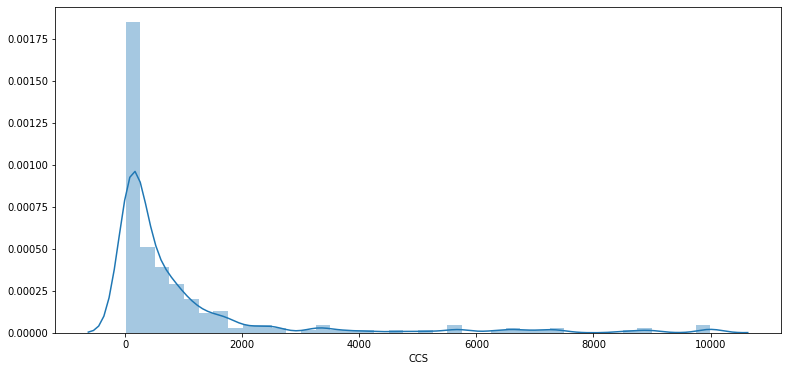

In [118]:
plt.figure(figsize=(13,6))
sns.distplot(a=df['CCS'])

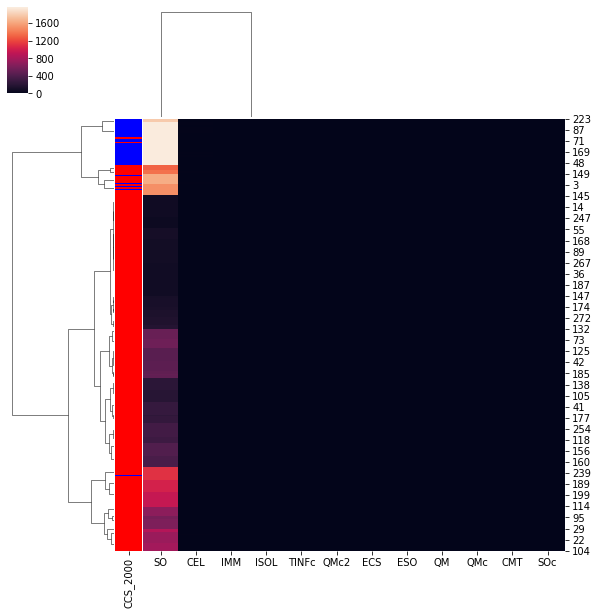

In [119]:
lut = dict(zip(df['CCS_%i'%best_index].unique(), "rbg"))
row_colors = df['CCS_%i'%best_index].map(lut)
g = sns.clustermap(df[columns],row_colors=row_colors)